<a href="https://colab.research.google.com/github/michp15/Big_Data/blob/main/text_analysis_topic_detection_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Project

## Install Libraries

In [1]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 11.6 MB/s eta 0:00:00


## Import Libraries

In [57]:
# PySpark Core
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, lit, udf, when
from pyspark.sql.types import ArrayType, DoubleType, IntegerType, StringType, StructType, StructField
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import (
    DecisionTreeClassifier, GBTClassifier, LinearSVC,
    LogisticRegression, NaiveBayes, RandomForestClassifier,
    FMClassifier, LogisticRegressionModel
)
from pyspark.ml.clustering import KMeans, LDA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import (
    CountVectorizer, HashingTF, IDF, StopWordsRemover,
    RegexTokenizer
)
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.stat import Summarizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Python standard libraries
import time
import os

# NLTK for lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# NumPy
import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initialize Spark session

In [4]:
# Set adequate amount of RAM

spark = SparkSession.builder \
    .appName("App") \
    .master("local[*]") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

In [5]:
#.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.5.3") \
#.config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.4-s_2.12")\

## Sentiment Analysis

In [ ]:
# Define Schema for review dataset

review_schema = StructType([
    StructField('stars', DoubleType(), True),
    StructField('text', StringType(), True)
])

In [ ]:
# Read review dataset

review = spark.read.schema(review_schema).parquet("/content/drive/MyDrive/2nd semester msc/Big Data/project/review.parquet")

In [ ]:
# Inspect dataset

review.show(5)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  5.0|Great little spot...|
|  5.0|James was super k...|
|  5.0|By far the best i...|
|  5.0|I thought that th...|
|  5.0|Aside from the re...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
# Print shape

(review.count(), len(review.columns))

(6990280, 2)

<Axes: title={'center': 'Star Distribution'}, xlabel='Stars', ylabel='Star Count'>

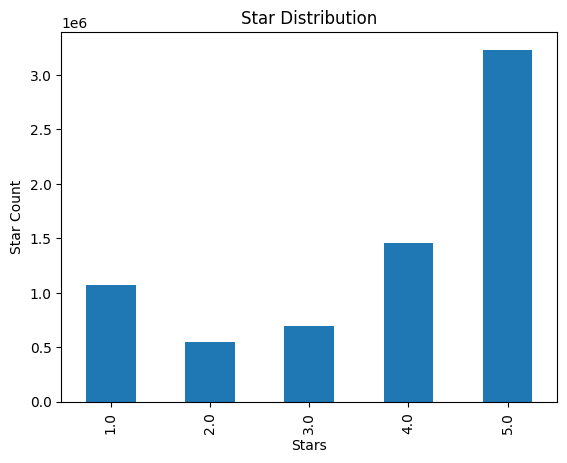

In [ ]:
# View star (rating) distribution

review.groupby('stars').count().toPandas().sort_values(by='stars').plot(kind='bar', x='stars', y='count', title='Star Distribution', xlabel='Stars', ylabel='Star Count', legend=False)

In [ ]:
# Filter out neutral reviews (stars=3), to avoid introducing noise and map stars to postive and negative sentiment (1, 0). Also remove stars column to preserve memory.

review = review.filter(col('stars') != 3).withColumn('sentiment', when(col('stars') >= 3, 1).otherwise(0)).select('text', 'sentiment')

In [ ]:
# Print shape

(review.count(), len(review.columns))

(6298346, 2)

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='Sentiment', ylabel='Sentiment Count'>

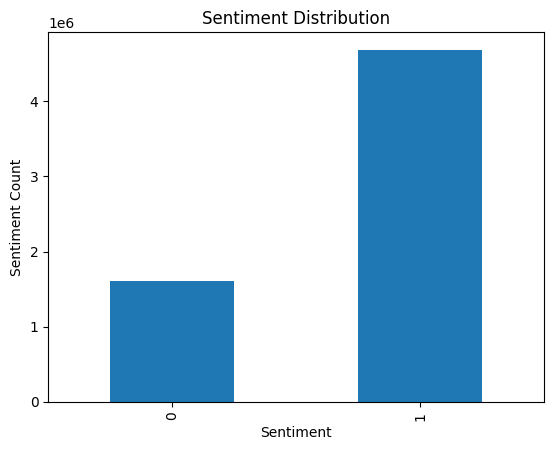

In [ ]:
# View sentiment distribution

review.groupby('sentiment').count().toPandas().sort_values(by='sentiment').plot(kind='bar', x='sentiment', y='count', title='Sentiment Distribution', xlabel='Sentiment', ylabel='Sentiment Count', legend=False)

In [ ]:
# Stratified sampling

ratios = [0.8, 0.2]

train_pos, test_pos = review.filter(col('sentiment')==1).randomSplit(ratios, seed=42)
train_neg, test_neg = review.filter(col('sentiment')==0).randomSplit(ratios, seed=42)

train, test = train_pos.union(train_neg), test_pos.union(test_neg)

<Axes: title={'center': 'Train Sentiment Distribution'}, xlabel='Sentiment', ylabel='Sentiment Count'>

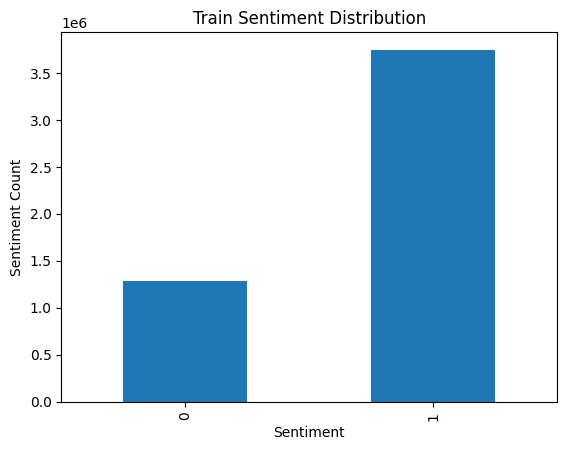

In [ ]:
# View train set sentiment distribution

train.groupby('sentiment').count().toPandas().sort_values(by='sentiment').plot(kind='bar', x='sentiment', y='count', title='Train Sentiment Distribution', xlabel='Sentiment', ylabel='Sentiment Count', legend=False)

In [ ]:
# Get the number of entries in train dataset

train.count()

5035688

<Axes: title={'center': 'Test Sentiment Distribution'}, xlabel='Sentiment', ylabel='Sentiment Count'>

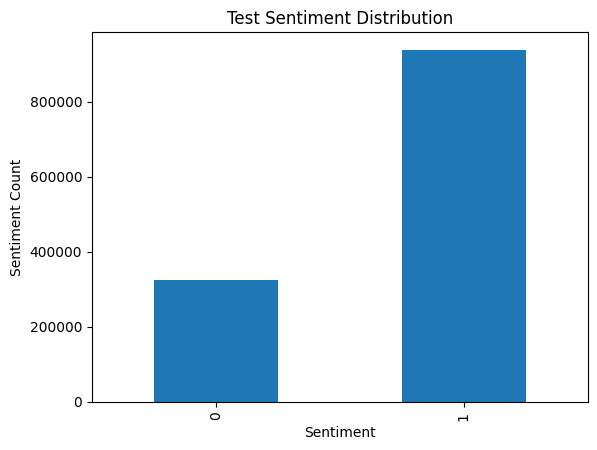

In [ ]:
# View test set sentiment distribution

test.groupby('sentiment').count().toPandas().sort_values(by='sentiment').plot(kind='bar', x='sentiment', y='count', title='Test Sentiment Distribution', xlabel='Sentiment', ylabel='Sentiment Count', legend=False)

In [ ]:
# Get the number of entries in the test dataset

test.count()

1262658

In [ ]:
# Add weight column for the algorithms

weights = train.groupBy('sentiment').agg((lit(train.count()) / count('*')).alias('weight'))
train = train.join(weights, on='sentiment', how='left')

In [ ]:
# Inspect train dataset

train.show(5)

+---------+--------------------+------------------+
|sentiment|                text|            weight|
+---------+--------------------+------------------+
|        1|!!Chicagoan Alert...|1.3443479161583225|
|        1|!!VEGAN OPTIONS!!...|1.3443479161583225|
|        1|!st of all, why a...|1.3443479161583225|
|        1|" That's A Robber...|1.3443479161583225|
|        1|"... I lived a fe...|1.3443479161583225|
+---------+--------------------+------------------+
only showing top 5 rows



In [ ]:
# Save train and test

#train.write.parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/train.parquet')
#test.write.parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test.parquet')

In [ ]:
# Load train and test (new runtime)

train_schema = StructType([
    StructField('text', StringType(), True),
    StructField('sentiment', IntegerType(), True),
    StructField('weight', DoubleType(), True)
])

test_schema = StructType([
    StructField('text', StringType(), True),
    StructField('sentiment', IntegerType(), True),
    StructField('weight', DoubleType(), True)
])

train = spark.read.schema(train_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/train.parquet')
test = spark.read.schema(test_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test.parquet')

In [ ]:
# Regex pattern (from slides with added segments for emojis)

pattern = r"(?:[A-Z]\.)+|\d+(?:\.\d+)?%?|\w+(?:[-']\w+)*|[+/\\\-@&*]|(?:#\w+)|(?:@\w+)|(?:\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])"

# Regex tokenizer

regex_tokenizer = RegexTokenizer(
    inputCol='text',
    outputCol='tokens',
    pattern=pattern,
    gaps=False,
    toLowercase=True
)

# Lemmatizer UDF (applied after tokenization)

lemmatizer = WordNetLemmatizer()

@udf(ArrayType(StringType()))
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Stopword remover

stopwords_remover = StopWordsRemover(
    inputCol='lemma',
    outputCol='clean_tokens'
)

# TF-IDF

hashing_tf = HashingTF(inputCol='clean_tokens', outputCol='raw_features', numFeatures=10000)
idf = IDF(inputCol='raw_features', outputCol='features')

# Pipeline (without UDF stage, applied manually)

pipeline = Pipeline(stages=[
    regex_tokenizer,
    stopwords_remover,
    hashing_tf,
    idf
])

In [ ]:
# Tokenize train
tokenizer_model = Pipeline(stages=[regex_tokenizer]).fit(train)
train_tokenized = tokenizer_model.transform(train)

# Lemmatize train
train_tokenized = train_tokenized.withColumn('lemma', lemmatize_tokens('tokens'))

# Apply stopword removal + TF-IDF
rest_pipeline = Pipeline(stages=[
    stopwords_remover,
    hashing_tf,
    idf
])
rest_model = rest_pipeline.fit(train_tokenized)
train_transformed = rest_model.transform(train_tokenized)

# Tokenize test
test_tokenized = tokenizer_model.transform(test)

# Lemmatize test
test_tokenized = test_tokenized.withColumn('lemma', lemmatize_tokens('tokens'))

# Transform test
test_transformed = rest_model.transform(test_tokenized)

In [ ]:
# Save train_transformed and test_transformed

#train_transformed.write.parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/train_transformed.parquet')
#test_transformed.write.parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test_transformed.parquet')

In [ ]:
# Load train_transformed and test_transformed

train_schema = StructType([
    StructField('features', VectorUDT(), True),
    StructField('sentiment', IntegerType(), True),
    StructField('weight', DoubleType(), True)
])

test_schema = StructType([
    StructField('features', VectorUDT(), True),
    StructField('sentiment', IntegerType(), True)
])

train_transformed = spark.read.schema(train_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/train_transformed.parquet')
test_transformed = spark.read.schema(test_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test_transformed.parquet')

In [ ]:
# Inspect train_transformed

train_transformed.show(5)

+--------------------+---------+-----------------+
|            features|sentiment|           weight|
+--------------------+---------+-----------------+
|(10000,[18,94,129...|        0|3.904039644428181|
|(10000,[332,468,4...|        0|3.904039644428181|
|(10000,[1,87,196,...|        0|3.904039644428181|
|(10000,[55,387,48...|        0|3.904039644428181|
|(10000,[1154,1369...|        0|3.904039644428181|
+--------------------+---------+-----------------+
only showing top 5 rows



In [ ]:
# Inspect train_transformed sentiment counts

train_transformed.groupBy('sentiment').count().show()

+---------+-------+
|sentiment|  count|
+---------+-------+
|        0| 978878|
|        1|3745822|
+---------+-------+



In [ ]:
# Inspect test_transformed

test_transformed.show(5)

+--------------------+---------+
|            features|sentiment|
+--------------------+---------+
|(10000,[80,182,32...|        0|
|(10000,[86,349,35...|        0|
|(10000,[298,1738,...|        0|
|(10000,[258,527,8...|        0|
|(10000,[157,694,8...|        0|
+--------------------+---------+
only showing top 5 rows



In [ ]:
# Inspect test_transformed sentiment counts

test_transformed.groupBy('sentiment').count().show()

+---------+------+
|sentiment| count|
+---------+------+
|        0|323935|
|        1|938723|
+---------+------+



In [ ]:
# Training and testing phase

# Evaluator for binary F1 score
evaluator = MulticlassClassificationEvaluator(
    labelCol='sentiment',
    predictionCol='prediction',
    metricName='f1'
)

# Directory to save models and predictions
base_path = '/content/drive/MyDrive/2nd semester msc/Big Data/project/models'

# Define models
models = {
    'Logistic Regression': LogisticRegression(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Decision Tree': DecisionTreeClassifier(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Random Forest': RandomForestClassifier(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Gradient Boosted Trees': GBTClassifier(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Linear SVM': LinearSVC(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Naive Bayes': NaiveBayes(featuresCol='features', labelCol='sentiment', weightCol='weight'),
    'Factorization Machines': FMClassifier(featuresCol='features', labelCol='sentiment')
}

# Train, predict, and evaluate
results = {}

for name, clf in models.items():
  try:
      print(f'\nTraining: {name}')

      # Create pipeline and train
      pipeline = Pipeline(stages=[clf])
      model = pipeline.fit(train_transformed)

      # Save the model
      model_path = os.path.join(base_path, f'{name}_model')
      model.write().overwrite().save(model_path)

      # Predict
      predictions = model.transform(test_transformed)

      # Save predictions
      predictions_path = os.path.join(base_path, f'{name}_predictions')
      predictions.select('sentiment', 'prediction', 'probability', 'features') \
                  .write.mode('overwrite').parquet(predictions_path)

      # Evaluate
      f1 = evaluator.evaluate(predictions)
      results[name] = round(f1, 4)
      print(f'F1 Score: {f1:.4f}')

  except Exception as e:
      results[name] = f'Failed: {str(e)}'
      print(f'{name} failed: {e}')

# Final summary
print('\n=== F1 Score Summary ===')
for name, score in results.items():
    print(f'{name}: {score}')


Training: Logistic Regression
F1 Score: 0.9488

Training: Decision Tree
F1 Score: 0.7159

Training: Random Forest
F1 Score: 0.7595

Training: Gradient Boosted Trees
F1 Score: 0.8505

Training: Linear SVM
Linear SVM failed: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `probability` cannot be resolved. Did you mean one of the following? [`features`, `prediction`, `sentiment`, `rawPrediction`].;
'Project [sentiment#7, prediction#631, 'probability, features#6]
+- Project [features#6, sentiment#7, rawPrediction#624, UDF(rawPrediction#624) AS prediction#631]
   +- Project [features#6, sentiment#7, UDF(features#6) AS rawPrediction#624]
      +- Relation [features#6,sentiment#7] parquet


Training: Naive Bayes
F1 Score: 0.8810

Training: Factorization Machines
F1 Score: 0.9220

=== F1 Score Summary ===
Logistic Regression: 0.9488
Decision Tree: 0.7159
Random Forest: 0.7595
Gradient Boosted Trees: 0.8505
Linear SVM: Failed: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A 

In [ ]:
# Training and testing linear SVM again to overcome error

# Evaluator for binary F1 score
evaluator = MulticlassClassificationEvaluator(
    labelCol='sentiment',
    predictionCol='prediction',
    metricName='f1'
)

# Directory to save models and predictions
base_path = '/content/drive/MyDrive/2nd semester msc/Big Data/project/models'

# Define models
models_svm = {
    'Linear SVM': LinearSVC(featuresCol='features', labelCol='sentiment', weightCol='weight'),
}

# Train, predict, and evaluate
results_svm = {}

for name, clf in models_svm.items():
  try:
      print(f'\nTraining: {name}')

      # Create pipeline and train
      pipeline = Pipeline(stages=[clf])
      model = pipeline.fit(train_transformed)

      # Save the model
      model_path = os.path.join(base_path, f'{name}_model')
      model.write().overwrite().save(model_path)

      # Predict
      predictions = model.transform(test_transformed)

      # Save predictions
      predictions_path = os.path.join(base_path, f'{name}_predictions')
      predictions.select('sentiment', 'prediction', 'features') \
                  .write.mode('overwrite').parquet(predictions_path)

      # Evaluate
      f1 = evaluator.evaluate(predictions)
      results_svm[name] = round(f1, 4)
      print(f'F1 Score: {f1:.4f}')

  except Exception as e:
      results_svm[name] = f'Failed: {str(e)}'
      print(f'{name} failed: {e}')

# Final summary
print('\n=== F1 Score Summary ===')
for name, score in results_svm.items():
    print(f'{name}: {score}')


Training: Linear SVM
F1 Score: 0.9487

=== F1 Score Summary ===
Linear SVM: 0.9487


In [ ]:
# Logistic regression and Linear SVM are the winners (virtually the same performace)
# Logistic regression is preferred to the benefits of added probabilities column  and better interpretability
# Logistic Regression, Linear SVM, Naive Bayes were really fast
# FM Classifier was also fast

In [ ]:
# Finetune selected best model (Logistic Regression)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='sentiment',
    weightCol='weight',
    predictionCol='prediction',
    probabilityCol='probability'
)

evaluator = MulticlassClassificationEvaluator(
    labelCol='sentiment',
    predictionCol='prediction',
    metricName='f1'
)

# Parameters to test
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.threshold, [0.3, 0.4, 0.5, 0.6, 0.7]) \
    .build()

# CrossValidator setup
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

# Fit on training data
cv_model = cv.fit(train_transformed)

# Predict on test data
predictions = cv_model.transform(test_transformed)

# Evaluate on test data
f1_score = evaluator.evaluate(predictions)
print(f'Final Test F1 Score: {f1_score:.4f}')

# Extract best model
best_model = cv_model.bestModel

print('\nBest Model Hyperparameters:')
print(f'  regParam:         {best_model._java_obj.getRegParam()}')
print(f'  elasticNetParam:  {best_model._java_obj.getElasticNetParam()}')
print(f'  threshold:        {best_model._java_obj.getThreshold()}')

Final Test F1 Score: 0.9494

Best Model Hyperparameters:
  regParam:         0.01
  elasticNetParam:  0.0
  threshold:        0.4


In [ ]:
# Save paths
model_path = '/content/drive/MyDrive/2nd semester msc/Big Data/project/best_model/model'
pred_path = '/content/drive/MyDrive/2nd semester msc/Big Data/project/best_model/predictions'

# Save best model
best_model.write().overwrite().save(model_path)
print(f'\nBest model saved to: {model_path}')

# Save best model predictions
predictions.select('sentiment', 'prediction', 'probability', 'features') \
    .write.mode('overwrite').parquet(pred_path)
print(f'Predictions saved to: {pred_path}')


Best model saved to: /content/drive/MyDrive/2nd semester msc/Big Data/project/best_model/model
Predictions saved to: /content/drive/MyDrive/2nd semester msc/Big Data/project/best_model/predictions


## Inference Time and Throughput

In [44]:
# Load data and models for inference

# Load test_transformed (new runtime)

test_schema = StructType([
    StructField('features', VectorUDT(), True),
])

test_transformed = spark.read.schema(test_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test_transformed.parquet')

# Load models

lr_best = LogisticRegressionModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/best_model/model')
lr = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Logistic Regression_model')
rf = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Random Forest_model')
nb = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Naive Bayes_model')
svc = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Linear SVM_model')
gbt = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Gradient Boosted Trees_model')
fm = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Factorization Machines_model')
dt = PipelineModel.load('/content/drive/MyDrive/2nd semester msc/Big Data/project/models/Decision Tree_model')

# Store models in a list with their names

models = [('lr_best', lr_best), ('lr', lr), ('rf', rf), ('nb', nb), ('svc', svc), ('gbt', gbt), ('fm', fm), ('dt', dt)]

In [56]:
# Calculate inference times and throughputs

inference_times = {}
n_runs = 5  # Number of runs for averaging

# Compute once outside the loop to avoid recomputing
num_samples = test_transformed.count()

for model_name, model_object in models:
    total_duration = 0.0
    for _ in range(n_runs):
        start_time = time.time()
        model_object.transform(test_transformed).count()  # trigger execution
        end_time = time.time()
        total_duration += (end_time - start_time)

    avg_duration = total_duration / n_runs
    inference_times[model_name] = avg_duration

# Print inference times and throughput
for model_name, duration in inference_times.items():
  samples_per_sec = num_samples / duration
  print(f'{model_name}: {duration:.4f} sec avg total, {duration/num_samples:.10f} sec/sample, {samples_per_sec:.2f} samples/sec')

lr_best: 0.2617 sec avg total, 0.0000002072 sec/sample, 4825716.96 samples/sec
lr: 0.2589 sec avg total, 0.0000002051 sec/sample, 4876533.98 samples/sec
rf: 0.2551 sec avg total, 0.0000002020 sec/sample, 4950146.36 samples/sec
nb: 0.2635 sec avg total, 0.0000002087 sec/sample, 4792187.95 samples/sec
svc: 0.2434 sec avg total, 0.0000001928 sec/sample, 5187973.46 samples/sec
gbt: 0.2585 sec avg total, 0.0000002047 sec/sample, 4884657.00 samples/sec
fm: 0.2506 sec avg total, 0.0000001985 sec/sample, 5037967.13 samples/sec
dt: 0.2593 sec avg total, 0.0000002053 sec/sample, 4869745.11 samples/sec


## Topic Detection

In [8]:
# Load train_transformed and test_transformed (new runtime)

train_schema = StructType([
    StructField('clean_tokens', ArrayType(StringType()), True),
    StructField('sentiment', IntegerType(), True)
])

test_schema = StructType([
    StructField('clean_tokens', ArrayType(StringType()), True),
    StructField('sentiment', IntegerType(), True)
])

train_transformed = spark.read.schema(train_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/train_transformed.parquet')
test_transformed = spark.read.schema(test_schema).parquet('/content/drive/MyDrive/2nd semester msc/Big Data/project/test_transformed.parquet')

In [9]:
# Inspect train_transformed

train_transformed.show(5)

+--------------------+---------+
|        clean_tokens|sentiment|
+--------------------+---------+
|[nooooo, mouth, f...|        0|
|[buyer, beware, a...|        0|
|[dealer, people, ...|        0|
|[amusement, park,...|        0|
|[chicken, giant, ...|        0|
+--------------------+---------+
only showing top 5 rows



In [10]:
# Get train_transformed shape

(train_transformed.count(), len(train_transformed.columns))

(4724700, 2)

In [11]:
# Inspect test_transformed

test_transformed.show(5)

+--------------------+---------+
|        clean_tokens|sentiment|
+--------------------+---------+
|[0, star, f, plac...|        0|
|[30, -, 35, min, ...|        0|
|[discount, liquor...|        0|
|[fast, curbside, ...|        0|
|[grilled, chicken...|        0|
+--------------------+---------+
only showing top 5 rows



In [12]:
# Get test_transformed shape

(test_transformed.count(), len(test_transformed.columns))

(1262658, 2)

In [13]:
# Merge datasets into one

combined_df = train_transformed.union(test_transformed)

In [14]:
# Inspect combined_df

combined_df.show(5)

+--------------------+---------+
|        clean_tokens|sentiment|
+--------------------+---------+
|[nooooo, mouth, f...|        0|
|[buyer, beware, a...|        0|
|[dealer, people, ...|        0|
|[amusement, park,...|        0|
|[chicken, giant, ...|        0|
+--------------------+---------+
only showing top 5 rows



In [15]:
# Get combined_df shape

(combined_df.count(), len(combined_df.columns))

(5987358, 2)

In [16]:
# Add weight column for the algorithms

weights = combined_df.groupBy('sentiment').agg((lit(combined_df.count()) / count('*')).alias('weight'))
combined_df = combined_df.join(weights, on='sentiment', how='left')

In [17]:
# Inspecdt combined_df

combined_df.show(5)

+---------+--------------------+-----------------+
|sentiment|        clean_tokens|           weight|
+---------+--------------------+-----------------+
|        0|[nooooo, mouth, f...|4.595715578521246|
|        0|[buyer, beware, a...|4.595715578521246|
|        0|[dealer, people, ...|4.595715578521246|
|        0|[amusement, park,...|4.595715578521246|
|        0|[chicken, giant, ...|4.595715578521246|
+---------+--------------------+-----------------+
only showing top 5 rows



In [18]:
# Define a count vectorizer to create a feature vector from the filtered text
vectorizer = CountVectorizer() \
.setInputCol("clean_tokens") \
.setOutputCol("features") \
.setVocabSize(10000) \
.setMinDF(5) \
.fit(combined_df)

In [19]:
# Transform to get vectors

combined_df = vectorizer.transform(combined_df)

In [21]:
# Inspect combined_df

combined_df.show(5)

+---------+--------------------+-----------------+--------------------+
|sentiment|        clean_tokens|           weight|            features|
+---------+--------------------+-----------------+--------------------+
|        0|[nooooo, mouth, f...|4.595715578521246|(10000,[0,1,3,5,8...|
|        0|[buyer, beware, a...|4.595715578521246|(10000,[4,7,8,10,...|
|        0|[dealer, people, ...|4.595715578521246|(10000,[0,2,5,8,9...|
|        0|[amusement, park,...|4.595715578521246|(10000,[0,1,5,6,3...|
|        0|[chicken, giant, ...|4.595715578521246|(10000,[42,181,24...|
+---------+--------------------+-----------------+--------------------+
only showing top 5 rows



In [22]:
# Get vocabulary list

vocab_list = vectorizer.vocabulary

In [23]:
# Apply Kmeans for topic detection

# Set up KMeans
kmeans = KMeans(k=10, featuresCol='features', predictionCol='topic', weightCol='weight', seed=42)
model = kmeans.fit(combined_df)

# Predict clusters (topics)
combined_df = model.transform(combined_df)

In [25]:
# Rename topic column to kmeans_topic

combined_df = combined_df.withColumnRenamed('topic', 'kmeans_topic')

In [26]:
# See topics

topics = combined_df.groupBy("kmeans_topic").\
                    agg(Summarizer.mean(combined_df.features)).\
                    select(["kmeans_topic","mean(features)"]).collect()

topics = [(i["kmeans_topic"], i["mean(features)"]) for i in topics]

for topic in topics:
  print("Topic ID:" + str(topic[0]))
  top_k = np.partition(topic[1], -5)[-5:]
  for term in range(len(topic[1])):
    if topic[1][term] in top_k:
      print(vocab_list[round(term)])
  print("------------------")

Topic ID:1
wa
food
place
great
good
------------------
Topic ID:6
wa
time
get
one
like
------------------
Topic ID:3
wa
food
time
u
order
------------------
Topic ID:5
wa
food
place
time
get
------------------
Topic ID:9
wa
time
get
back
told
------------------
Topic ID:4
wa
food
place
good
-
------------------
Topic ID:8
wa
time
-
one
/
------------------
Topic ID:7
wa
good
-
one
like
------------------
Topic ID:2
wa
food
place
good
like
------------------
Topic ID:0
wa
food
place
great
good
------------------


In [59]:
topics = combined_df.groupBy("kmeans_topic").\
                    agg(Summarizer.mean(combined_df.features)).\
                    select(["kmeans_topic","mean(features)"]).collect()

topics = [(i["kmeans_topic"], i["mean(features)"]) for i in topics]

for topic in topics:
  print("Topic ID:" + str(topic[0]))
  top_k = np.partition(topic[1], -20)[-20:]
  for term in range(len(topic[1])):
    if topic[1][term] in top_k:
      print(vocab_list[round(term)])
  print("------------------")

Topic ID:1
wa
food
place
great
good
time
service
get
one
like
back
go
really
also
u
got
restaurant
nice
delicious
ordered
------------------
Topic ID:6
wa
food
place
good
time
-
service
get
one
like
back
go
really
also
u
got
even
came
said
told
------------------
Topic ID:3
wa
food
place
good
time
service
get
one
like
back
go
u
got
restaurant
order
ordered
came
drink
table
minute
------------------
Topic ID:5
wa
food
place
great
good
time
-
service
get
one
like
back
go
really
also
even
order
ha
always
make
------------------
Topic ID:9
wa
time
service
get
one
like
back
go
u
got
even
day
never
said
customer
told
asked
car
called
call
------------------
Topic ID:4
wa
food
place
great
good
time
-
service
get
one
like
back
go
really
also
even
restaurant
well
ha
/
------------------
Topic ID:8
wa
food
place
great
good
time
-
service
get
one
like
back
really
also
order
day
/
2
review
*
------------------
Topic ID:7
wa
food
place
great
good
time
-
service
get
one
like
back
go
really
also
u
ev

In [27]:
# Inspect combined_df

combined_df.show(5)

+---------+--------------------+-----------------+--------------------+------------+
|sentiment|        clean_tokens|           weight|            features|kmeans_topic|
+---------+--------------------+-----------------+--------------------+------------+
|        0|[nooooo, mouth, f...|4.595715578521246|(10000,[0,1,3,5,8...|           3|
|        0|[buyer, beware, a...|4.595715578521246|(10000,[4,7,8,10,...|           5|
|        0|[dealer, people, ...|4.595715578521246|(10000,[0,2,5,8,9...|           6|
|        0|[amusement, park,...|4.595715578521246|(10000,[0,1,5,6,3...|           2|
|        0|[chicken, giant, ...|4.595715578521246|(10000,[42,181,24...|           0|
+---------+--------------------+-----------------+--------------------+------------+
only showing top 5 rows



In [32]:
# Do LDA now

# Select the features vector
count_vectors = combined_df.select("features")

# Define LDA model with 10 topics
lda = LDA(k=10, seed=42)

# Fit the LDA model
lda_model = lda.fit(count_vectors)

# Print the results

# Take topic vectors
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 5)

# Print the final topics
for topic in topicIndices.collect():
  print("Topic ID:" + str(topic["topic"]))
  for term in topic["termIndices"]:
    print(vocab_list[term])
  print("------------------")

Topic ID:0
wa
time
get
back
service
------------------
Topic ID:1
wa
food
good
time
service
------------------
Topic ID:2
food
place
good
best
always
------------------
Topic ID:3
wa
great
food
place
good
------------------
Topic ID:4
great
place
wa
coffee
good
------------------
Topic ID:5
wa
food
u
drink
bar
------------------
Topic ID:6
wa
car
great
-
time
------------------
Topic ID:7
wa
place
like
*
get
------------------
Topic ID:8
-
wa
cheese
good
sandwich
------------------
Topic ID:9
wa
good
pizza
ordered
sauce
------------------


In [58]:
# Take topic vectors
topicIndices = lda_model.describeTopics(maxTermsPerTopic = 20)

# Print the final topics
for topic in topicIndices.collect():
  print("Topic ID:" + str(topic["topic"]))
  for term in topic["termIndices"]:
    print(vocab_list[term])
  print("------------------")

Topic ID:0
wa
time
get
back
service
one
told
said
customer
never
day
go
even
called
like
place
u
call
went
-
------------------
Topic ID:1
wa
food
good
time
service
breakfast
place
u
back
ordered
came
got
really
-
one
like
great
egg
order
restaurant
------------------
Topic ID:2
food
place
good
best
always
get
go
great
love
time
one
like
price
service
ha
pizza
restaurant
make
wa
friendly
------------------
Topic ID:3
wa
great
food
place
good
service
delicious
amazing
restaurant
definitely
time
back
chicken
friendly
recommend
really
also
best
menu
fresh
------------------
Topic ID:4
great
place
wa
coffee
good
nice
love
like
get
time
one
room
staff
beer
friendly
also
food
bar
really
go
------------------
Topic ID:5
wa
food
u
drink
bar
table
time
great
place
back
service
one
get
minute
good
order
night
came
go
server
------------------
Topic ID:6
wa
car
great
-
time
store
service
work
get
one
ha
year
new
recommend
like
price
also
need
experience
day
------------------
Topic ID:7
wa
place
